In [1]:
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import datetime
from tqdm import tqdm
import random
import json
import os
%matplotlib inline

DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [2]:
class NetworkDenseFc(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.head = torch.nn.Sequential(
            torch.nn.Linear(28**2, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),

            torch.nn.Linear(256, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),

            torch.nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.head(torch.flatten(x, 1))

In [3]:
class NetworkCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = torch.nn.Sequential(
            # Shape 1x28x28
            torch.nn.Conv2d(3, 8, (3, 3), padding=1, stride=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.MaxPool2d((2, 2)), # 14x14
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # Shape 8x14x14
            torch.nn.Conv2d(8, 32, (3, 3), padding=1, stride=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.MaxPool2d((2, 2)), # 7x7
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # Shape 32x7x7
        )
        self.head = torch.nn.Sequential(
            torch.nn.Linear(32*7*7, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),

            torch.nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.backbone(x) # convolutions
        x = torch.flatten(x, 1) # flatten
        x = self.head(x) # classification head
        return x

In [4]:
class NetworkCNNTransfer(torch.nn.Module):
    def __init__(self, reference_model, fine_tune, get_head_in_features, set_head):
        super().__init__()
        # Save reference model as property.
        self.model = reference_model
        # Disable gradient descent / optimization for all params in the pre-trained model.
        if fine_tune:
            for p in self.model.parameters():
                p.requires_grad = False
        # Replace the head of the model with a custom head that fits the MNIST dataset.
        set_head(self.model, torch.nn.Sequential(
            # Basic fc block 1
            torch.nn.Linear(get_head_in_features(self.model), 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            # Reduce to n_classes=10 (MNIST [0..9]).
            torch.nn.Linear(128, 10),
        ))

    def forward(self, x):
        # Run x through the model.
        return self.model(x)

In [5]:
class NetworkResNet(torch.nn.Module):
    class BasicBlock(torch.nn.Module):
        def __init__(self, in_planes, out_planes, stride, modify_residual):
            super().__init__()
            self.layers = torch.nn.Sequential(
                torch.nn.Conv2d(in_planes, out_planes, (3, 3), stride=stride, padding=1),
                torch.nn.BatchNorm2d(out_planes),
                torch.nn.ReLU(),
                torch.nn.Conv2d(out_planes, out_planes, (3, 3), stride=1, padding=1),
                torch.nn.BatchNorm2d(out_planes),
            )
            self.modify_residual = modify_residual
            self.act = torch.nn.ReLU()

        def forward(self, x):
            residual = x
            x = self.layers(x)
            if self.modify_residual is not None:
                residual = self.modify_residual(residual)
            x += residual
            return self.act(x)

    def __init__(self, block, n_classes) -> None:
        super().__init__()
        self.backbone = torch.nn.Sequential(
            # 1x 28x28
            self._make_layer(block, 1, 16, 3, 2), # 16x 14x14
            self._make_layer(block, 16, 32, 4, 2), # 32x 7x7
        )
        self.head = torch.nn.Sequential(
            # torch.nn.AdaptiveAvgPool2d((7,7)),
            torch.nn.Flatten(),

            torch.nn.Linear(32 * (7*7), 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4),

            torch.nn.Linear(128, n_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.backbone(x)
        x = self.head(x)
        return x

    def _make_layer(self, block, in_channels, out_channels, num_blocks, stride):
        modify_residual = None
        if (stride != 1) or (out_channels != in_channels): # dimension matching
            modify_residual = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_channels)
            )
        blocks = [
            block(in_channels, out_channels, stride, modify_residual),
        ]
        for i in range(1, num_blocks):
            blocks.append(block(out_channels, out_channels, 1, None))
        return torch.nn.Sequential(*blocks)

In [6]:
def load_data(dataset, batch_size, validate_size, grayscale=1):
    mean_std_dl = DataLoader(dataset(root="datasets", train=True, download=True, transform=T.ToTensor()), batch_size=batch_size, shuffle=False)
    dataset_mean = 0.0
    dataset_std = 0.0
    dataset_samples = 0
    for data in mean_std_dl:
        batch_samples = data[0].size(0)
        data = data[0].view(batch_samples, data[0].size(1) * data[0].size(2) * data[0].size(3))
        dataset_mean += data.mean(1).sum(0)
        dataset_std += data.std(1).sum(0)
        dataset_samples += batch_samples
    dataset_mean /= dataset_samples
    dataset_std /= dataset_samples

    transforms = {
        'raw': T.Compose([
                T.Grayscale(grayscale),
                T.ToTensor(),
                T.Normalize(mean=dataset_mean, std=dataset_std),
            ]),
        'train': T.Compose([
                T.Resize((40, 40)),
                T.RandomCrop((32, 32)),
                T.RandomRotation(180),
                T.Resize((28, 28)),
                T.Grayscale(grayscale),
                T.ToTensor(),
                T.Normalize(mean=dataset_mean, std=dataset_std),
            ]),
        'validate': T.Compose([
                T.Grayscale(grayscale),
                T.ToTensor(),
                T.Normalize(mean=dataset_mean, std=dataset_std),
            ]),
        'test': T.Compose([
                T.Grayscale(grayscale),
                T.ToTensor(),
                T.Normalize(mean=dataset_mean, std=dataset_std),
            ]),
    }

    raw_data = dataset(root="datasets", train=True, download=False, transform=transforms['raw'])
    train_data = dataset(root="datasets", train=True, download=False, transform=transforms['train'])
    test_data = dataset(root="datasets", train=False, download=False, transform=transforms['validate'])

    dataset_size = len(train_data)
    dataset_indices = list(range(dataset_size))
    dataset_split_at = int(np.floor(validate_size * dataset_size))
    np.random.shuffle(dataset_indices)

    train_sampler = torch.utils.data.SubsetRandomSampler(dataset_indices[dataset_split_at:])
    validate_sampler = torch.utils.data.SubsetRandomSampler(dataset_indices[:dataset_split_at])

    return {
        'raw': DataLoader(raw_data, batch_size=batch_size, shuffle=False),
        'train': DataLoader(train_data, sampler=train_sampler, batch_size=batch_size),
        'validate': DataLoader(train_data, sampler=validate_sampler, batch_size=batch_size),
        'test': DataLoader(test_data, batch_size=batch_size, shuffle=False),
    }

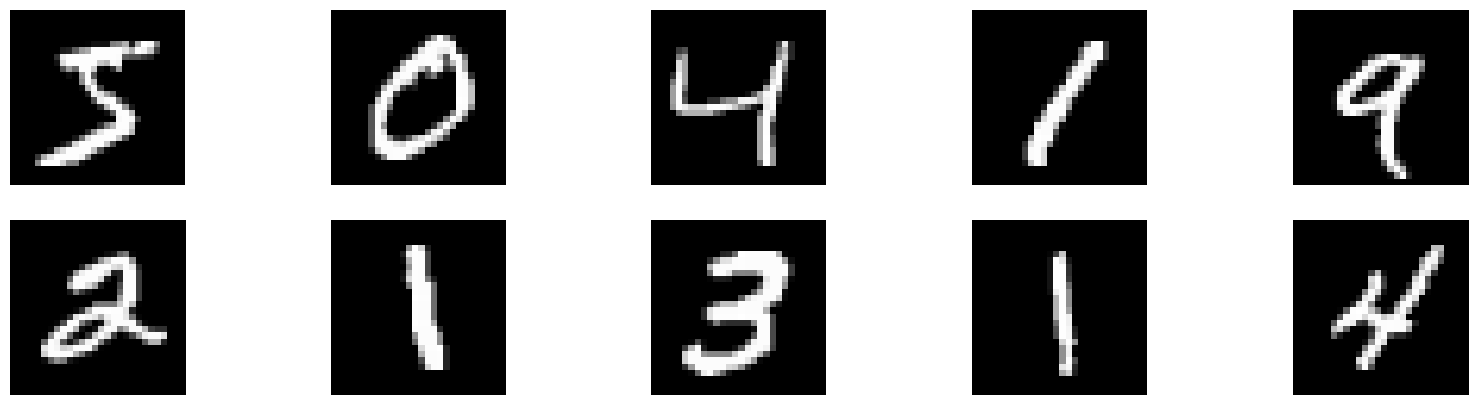

In [7]:
data = load_data(datasets.MNIST, 32, 0.2, 1)
fig, subs = plt.subplots(2, 5, figsize=(20, 5))
data_iter = next(iter(data['raw']))
images, labels = data_iter
images = images.numpy()
for i, sub in enumerate(subs.flatten()):
    img = np.squeeze(images[i])
    sub.imshow(img, cmap='gray')
    sub.axis('off')

In [8]:
def train(model, data, criterion, save_path):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)

    phase_loss_hist = {
        'train': [],
        'validate': [],
    }
    phase_acc_hist = {
        'train': [],
        'validate': [],
    }
    epoch_time_hist = []
    lr_hist = []
    best_val_loss = np.inf

    for epoch in range(30):
        lr_hist.append(optimizer.param_groups[0]['lr'])
        start_time = datetime.datetime.now()
        for phase in ['train', 'validate']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            data_len = len(data[phase])
            start_time = datetime.datetime.now() if phase == 'train' else start_time
            model.train()
            phase_correct = 0.0
            phase_loss = 0.0

            for i, d in tqdm(enumerate(data[phase]), desc=f'Epoch {epoch} ({phase} batches)', total=data_len):
                inputs, labels = d
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                _, preds = torch.max(outputs.data, 1)
                phase_correct += (preds == labels).float().mean().item()
                phase_loss += loss.item()

            phase_loss_hist[phase].append(phase_loss/data_len)
            phase_acc_hist[phase].append(phase_correct/data_len)

            if phase == 'validate':
                if phase_loss_hist[phase][-1] < best_val_loss:
                    best_val_loss = phase_loss_hist[phase][-1]
                    torch.save(model.state_dict(), save_path)
                lr_scheduler.step()

        elapsed = datetime.datetime.now() - start_time
        epoch_time_hist.append(elapsed.total_seconds())

        display.clear_output(wait=True)
        print(f'Epoch {epoch}')
        print(f'\t took {elapsed}')
        print(f'\t used learning rate {lr_hist[-1]}')
        print(f'\t Train Loss: {phase_loss_hist["train"][-1]:.2f} Train Accuracy: {phase_acc_hist["train"][-1]:.2f}')
        print(f'\t Validate Loss: {phase_loss_hist["validate"][-1]:.2f} Validate Accuracy: {phase_acc_hist["validate"][-1]:.2f}')
        # Graph for loss
        fig, plts = plt.subplots(1, 4, figsize=(15, 5))

        plts[0].title.set_text('Loss')
        plts[0].plot(phase_loss_hist['train'], label='Training')
        plts[0].plot(phase_loss_hist['validate'], label='Validation')
        # Graph for accuracy
        plts[1].title.set_text('Accuracy')
        plts[1].plot(phase_acc_hist['train'], label='Training')
        plts[1].plot(phase_acc_hist['validate'], label='Validation')
        # Graph for epoch time
        plts[2].title.set_text('Epoch time')
        plts[2].plot(epoch_time_hist, label='Elapsed')

        plts[3].title.set_text('Learning rate')
        plts[3].set_yscale('log')
        plts[3].plot(lr_hist, label='Training')
        # Display graphs
        for i in range(4):
            plts[i].legend()
        plt.show()


In [9]:
best_model_file = 'best-model.pth'
data = load_data(datasets.MNIST,
                batch_size=100,
                validate_size=0.2,
                grayscale=1)


Epoch 29
	 took 0:00:36.199823
	 used learning rate 0.009046039886902876
	 Train Loss: 0.24 Train Accuracy: 0.93
	 Validate Loss: 0.23 Validate Accuracy: 0.94


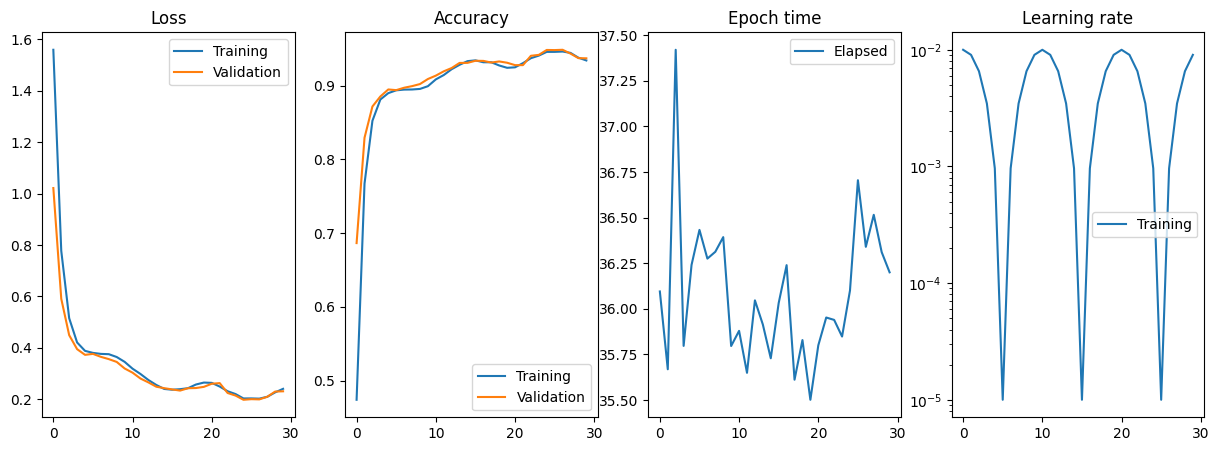

In [10]:
model = NetworkResNet(NetworkResNet.BasicBlock, 10).to(DEVICE)
train(
    model=model,
    data=data,
    criterion=torch.nn.CrossEntropyLoss(),
    save_path=best_model_file)

In [11]:
def test(model, data, criterion):
    model.eval()
    with torch.no_grad():
        data_test_len = len(data['test'])

        test_correct = 0.0
        test_loss = 0.0

        for i, d in enumerate(data['test']):
            inputs, labels = d
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs.data, 1)
            test_correct += (preds == labels).float().mean().item()
        print(f'Test Accuracy: {test_correct/data_test_len:.2f}')

model = NetworkResNet(NetworkResNet.BasicBlock, 10).to(DEVICE)
model.load_state_dict(torch.load(best_model_file))
test(model, data, torch.nn.CrossEntropyLoss())

Test Accuracy: 0.92
